In [27]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt


In [28]:
TRAIN_PATH = "/home/awail/PycharmProjects/kaggle/RoadAccident/train.csv"
TEST_PATH  = "/home/awail/PycharmProjects/kaggle/RoadAccident/train.csv"
OUTPUT_PATH = "/home/awail/PycharmProjects/kaggle/RoadAccident/submission4.csv"
RANDOM_STATE = 42

In [29]:
df = pd.read_csv(TRAIN_PATH)
if "id" in df.columns:
    df = df.drop("id", axis=1)

In [30]:
df["speed_limit_curvature"] = df["speed_limit"] * df["curvature"]
df["speed_limit_num_lanes"] = df["speed_limit"] * df["num_lanes"]
df["curvature_num_lanes"] = df["curvature"] * df["num_lanes"]

# lighting-weather textual combo (kept as categorical)
df["lighting_weather"] = df["lighting"].astype(str) + "_" + df["weather"].astype(str)

# numeric-coded lighting / weather for numeric interactions
df["lighting_numeric"] = df["lighting"].astype("category").cat.codes
df["weather_numeric"] = df["weather"].astype("category").cat.codes

# interactions discovered earlier
df["curvature_x_speed_limit"] = df["curvature"] * df["speed_limit"]
df["curvature_x_speed_limit_x_lighting"] = df["curvature"] * df["speed_limit"] * df["lighting_numeric"]
df["curvature_x_lighting"] = df["curvature"] * df["lighting_numeric"]
df["num_lanes_x_curvature_x_speed_limit"] = df["num_lanes"] * df["curvature"] * df["speed_limit"]
df["curvature_x_speed_limit_x_num_reported_accidents"] = df["curvature"] * df["speed_limit"] * df["num_reported_accidents"]
df["speed_limit_x_lighting"] = df["speed_limit"] * df["lighting_numeric"]
df["curvature_x_speed_limit_x_weather"] = df["curvature"] * df["speed_limit"] * df["weather_numeric"]
df["curvature_x_lighting_x_holiday"] = df["curvature"] * df["lighting_numeric"] * df["holiday"].astype(int)
df["speed_limit_x_weather_foggy"] = np.where(df["weather"].str.lower() == "foggy", df["speed_limit"], 0)

# temporal combined feature
df["school_time_holiday"] = (df["school_season"].astype(int) *
                             df["time_of_day"].astype("category").cat.codes *
                             df["holiday"].astype(int))


In [31]:
y = df["accident_risk"].values
X = df.drop("accident_risk", axis=1)

# identify categories / numerics
cat_cols = X.select_dtypes(include=["object", "bool", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()

print(f"Numeric columns count: {len(num_cols)}; Categorical columns count: {len(cat_cols)}")


Numeric columns count: 17; Categorical columns count: 9


In [32]:

# Example
num_cols = ["speed_limit", "curvature", "num_lanes", "num_reported_accidents"]
cat_cols = ["lighting", "weather", "time_of_day", "road_type", "holiday", "school_season"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
], remainder="drop")

X_processed = preprocessor.fit_transform(X)


In [33]:
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_processed, y, test_size=0.2, random_state=RANDOM_STATE
)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train_np, dtype=torch.float32, device=device).view(-1, 1)
X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
y_val = torch.tensor(y_val_np, dtype=torch.float32, device=device).view(-1, 1)

print(f"X_train shape (tensor): {X_train.shape}, y_train shape: {y_train.shape}")


Using device: cpu
X_train shape (tensor): torch.Size([414203, 20]), y_train shape: torch.Size([414203, 1])


In [25]:
class AccidentRiskModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.network(x)

input_dim = X_train.shape[1]
model = AccidentRiskModel(input_dim).to(device)

# choose optimizer / loss (adjusted to reduce over-regularization)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)


In [26]:
num_epochs = 100
batch_size = 1024
train_rmse, val_rmse = [], []

for epoch in range(1, num_epochs + 1):
    model.train()

    # shuffle indices on GPU (no CPU <-> GPU copies)
    perm = torch.randperm(X_train.size(0), device=device)
    X_train = X_train[perm]
    y_train = y_train[perm]

    total_loss = 0.0
    n_samples = X_train.size(0)

    for i in range(0, n_samples, batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)

    epoch_train_rmse = np.sqrt(total_loss / n_samples)

    # validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = criterion(val_preds, y_val).item()
        epoch_val_rmse = np.sqrt(val_loss)

    train_rmse.append(epoch_train_rmse)
    val_rmse.append(epoch_val_rmse)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{num_epochs} — Train RMSE: {epoch_train_rmse:.4f} | Val RMSE: {epoch_val_rmse:.4f}")



Epoch 1/100 — Train RMSE: 0.2592 | Val RMSE: 0.1277
Epoch 5/100 — Train RMSE: 0.0734 | Val RMSE: 0.0689
Epoch 10/100 — Train RMSE: 0.0685 | Val RMSE: 0.0642
Epoch 15/100 — Train RMSE: 0.0630 | Val RMSE: 0.0595
Epoch 20/100 — Train RMSE: 0.0612 | Val RMSE: 0.0588
Epoch 25/100 — Train RMSE: 0.0602 | Val RMSE: 0.0584
Epoch 30/100 — Train RMSE: 0.0596 | Val RMSE: 0.0580
Epoch 35/100 — Train RMSE: 0.0590 | Val RMSE: 0.0579
Epoch 40/100 — Train RMSE: 0.0587 | Val RMSE: 0.0579
Epoch 45/100 — Train RMSE: 0.0584 | Val RMSE: 0.0579
Epoch 50/100 — Train RMSE: 0.0582 | Val RMSE: 0.0581
Epoch 55/100 — Train RMSE: 0.0580 | Val RMSE: 0.0577
Epoch 60/100 — Train RMSE: 0.0579 | Val RMSE: 0.0580
Epoch 65/100 — Train RMSE: 0.0578 | Val RMSE: 0.0576
Epoch 70/100 — Train RMSE: 0.0577 | Val RMSE: 0.0575
Epoch 75/100 — Train RMSE: 0.0576 | Val RMSE: 0.0576
Epoch 80/100 — Train RMSE: 0.0576 | Val RMSE: 0.0577
Epoch 85/100 — Train RMSE: 0.0575 | Val RMSE: 0.0577
Epoch 90/100 — Train RMSE: 0.0574 | Val RMSE: 0.

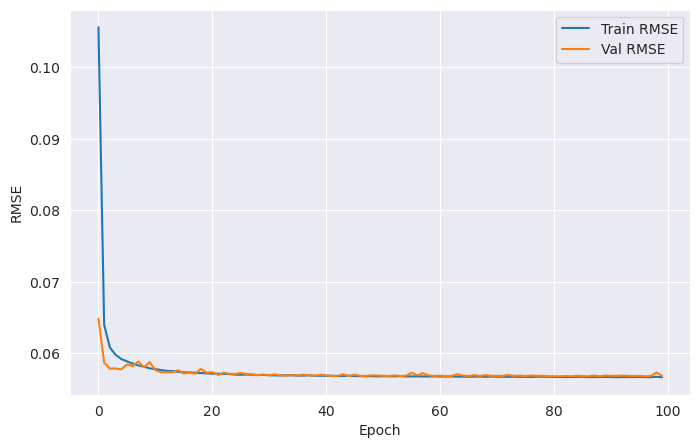

In [14]:
plt.figure(figsize=(8,5))
plt.plot(train_rmse, label="Train RMSE")
plt.plot(val_rmse, label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
torch.save(model.state_dict(), "neural_perm.ipynb")
print("Saved model: accident_risk_model_gpu_fixed.pth")


Saved model: accident_risk_model_gpu_fixed.pth


In [23]:
# -----------------------
# 11. prepare test set (apply exactly same engineered features + preprocessor)
# -----------------------
test_df = pd.read_csv("/home/awail/PycharmProjects/kaggle/RoadAccident/test.csv")
test_ids = test_df["id"].values if "id" in test_df.columns else np.arange(len(test_df))

# same engineered features on test set:
test_df["speed_limit_curvature"] = test_df["speed_limit"] * test_df["curvature"]
test_df["speed_limit_num_lanes"] = test_df["speed_limit"] * test_df["num_lanes"]
test_df["curvature_num_lanes"] = test_df["curvature"] * test_df["num_lanes"]
test_df["lighting_weather"] = test_df["lighting"].astype(str) + "_" + test_df["weather"].astype(str)
test_df["lighting_numeric"] = test_df["lighting"].astype("category").cat.codes
test_df["weather_numeric"] = test_df["weather"].astype("category").cat.codes

test_df["curvature_x_speed_limit"] = test_df["curvature"] * test_df["speed_limit"]
test_df["curvature_x_speed_limit_x_lighting"] = test_df["curvature"] * test_df["speed_limit"] * test_df["lighting"].astype("category").cat.codes
test_df["curvature_x_lighting"] = test_df["curvature"] * test_df["lighting"].astype("category").cat.codes
test_df["num_lanes_x_curvature_x_speed_limit"] = test_df["num_lanes"] * test_df["curvature"] * test_df["speed_limit"]
test_df["curvature_x_speed_limit_x_num_reported_accidents"] = test_df["curvature"] * test_df["speed_limit"] * test_df["num_reported_accidents"]
test_df["speed_limit_x_lighting"] = test_df["speed_limit"] * test_df["lighting"].astype("category").cat.codes
test_df["curvature_x_speed_limit_x_weather"] = test_df["curvature"] * test_df["speed_limit"] * test_df["weather"].astype("category").cat.codes
test_df["curvature_x_lighting_x_holiday"] = test_df["curvature"] * test_df["lighting"].astype("category").cat.codes * test_df["holiday"].astype(int)
test_df["speed_limit_x_weather_foggy"] = np.where(test_df["weather"].str.lower() == "foggy", test_df["speed_limit"], 0)
test_df["school_time_holiday"] = (test_df["school_season"].astype(int) * test_df["time_of_day"].astype("category").cat.codes * test_df["holiday"].astype(int))

#

In [24]:

# (Feature engineering as before...)

# --- Transform and predict ---
X_test = preprocessor.transform(test_df)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)

model.eval()
with torch.no_grad():
    preds = model(X_test).cpu().numpy().flatten()

# ✅ Match Kaggle sample submission format
submission = pd.DataFrame({
    "id": test_df["id"],             # keep same order
    "accident_risk": preds           # use correct column name
})

# --- 💾 Save to correct location ---
output_path = "/home/awail/PycharmProjects/kaggle/RoadAccident/submission5.csv"
submission.to_csv(output_path, index=False)
print(f"✅ Submission saved to {output_path}")
print(f"📊 Submission shape: {submission.shape}")


✅ Submission saved to /home/awail/PycharmProjects/kaggle/RoadAccident/submission5.csv
📊 Submission shape: (172585, 2)
